## TIME SERIES DECOMPOSITION & PREDICTION IN PYTHON
link: https://pythonforfinance.net/2019/07/22/time-series-decomposition-prediction-in-python/

We go straight into the main code by importing the necessary modules. We then read in the EURUSD data using Pandas, extract the relevant column and run it through both a Hodrick-Prescott Filter and an SYL decomposition separately. Just to note, the EURUSD file provided is “tab separated” rather than the more common “comma separated” hence we set sep="\t".

In [35]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AR

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

# include below line if you are using Jupyter Notebook
%matplotlib inline

# Set figure width to 12 and height to 9
plt.rcParams['figure.figsize'] = [12, 10]

df = pd.read_csv('/home/aj/Downloads/EURUSD.csv',sep='\t', index_col='Date')
df.index = pd.to_datetime(df.index)
df.sort_index(inplace=True)
df = df.resample('W').last()
series = df['Price']

In [2]:
def tsplot(y, lags=None, title='', figsize=(12, 6)):
    
    # Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    # Original source: https://tomaugspurger.github.io/modern-7-timeseries.html
    
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=30, alpha=.5)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    
    return ts_ax, acf_ax, pacf_ax

In [9]:
df.head()

,Price,Open,High,Low,Change %
Date,,,,,
2000-01-09,1.0292,1.0327,1.0333,1.0252,-0.31%
2000-01-16,1.0128,1.0261,1.0273,1.0111,-1.23%
2000-01-23,1.0091,1.0173,1.0193,1.0049,-0.83%
2000-01-30,0.9750,0.9880,0.9895,0.9738,-1.37%
2000-02-06,0.9828,0.9909,0.9941,0.9748,-0.76%


In [14]:
dfx = df.drop('Open', axis=1)
dfx = dfx.drop('High', axis=1)
dfx = dfx.drop('Low', axis=1)
dfx = dfx.drop('Change %', axis=1)
dfx.columns = ['EURUSD_Close']
dfx.head()

,EURUSD_Close
Date,
2000-01-09,1.0292
2000-01-16,1.0128
2000-01-23,1.0091
2000-01-30,0.9750
2000-02-06,0.9828


Index Dates: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

## Autocorrelation 
link: https://tomaugspurger.github.io/modern-7-timeseries.html

Another problem our lagged model suffered from is autocorrelation https://en.wikipedia.org/wiki/Autocorrelation (also know as serial correlation). Roughly speaking, autocorrelation is when there's a clear pattern in the residuals of your regression (the observed minus the predicted). Let's fit a simple model of $y = \beta_0 + \beta_1 T + \epsilon$, where T is the time trend (np.arange(len(y))).

Residuals (the observed minus the expected, or $\hat{e_t} = y_t - \hat{y_t}$) are supposed to be white noise. That's one of the assumptions many of the properties of linear regression are founded upon. In this case there's a correlation between one residual and the next: if the residual at time $t$ was above expectation, then the residual at time $t + 1$ is much more likely to be above average as well ($e_t > 0 \implies E_t[e_{t+1}] > 0$).

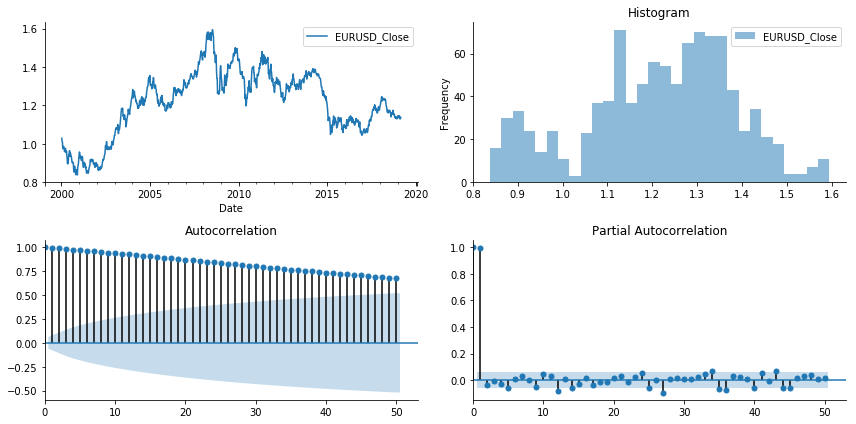

In [15]:
tsplot(dfx, lags=50);

The top subplot shows the time series of our residuals $e_t$, which should be white noise (but it isn't). The bottom shows the autocorrelation of the residuals as a correlogram. It measures the correlation between a value and it's lagged self, e.g. $corr(e_t, e_{t-1}), corr(e_t, e_{t-2}), \ldots$. The partial autocorrelation plot in the bottom-right shows a similar concept. It's partial in the sense that the value for $corr(e_t, e_{t-k})$ is the correlation between those two periods, after controlling for the values at all shorter lags.

## HP filter

The HP filter is a technique commonly used with macro-economic series that have a trend (long-term movements), business cycle and irregular parts (short-term fluctuations). It constructs the trend component by solving an optimisation problem. It aims to form the smoothest trend estimate that minimises the squared distances to the original series. In other words, it has to find equilibrium between the smoothness of the trend and its closeness to the original.

If you want to find out more about the details, you can do that https://en.wikipedia.org/wiki/Hodrick%E2%80%93Prescott_filter.

First the HP filter decomposition:

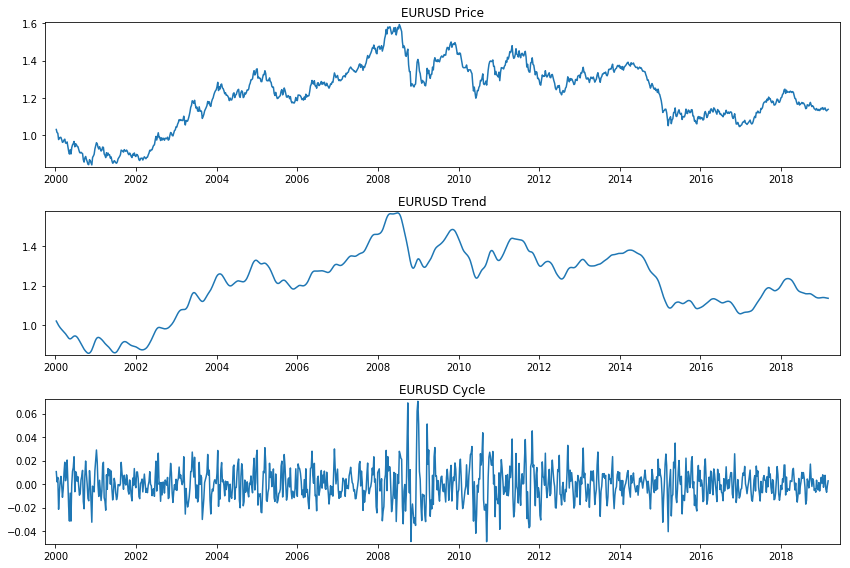

In [18]:
cycle, trend = sm.tsa.filters.hpfilter(series, 50)
fig, ax = plt.subplots(3,1, figsize=(12, 8))
ax[0].margins(0.015)
ax[1].margins(0.015)
ax[2].margins(0.015)
ax[0].plot(series)
ax[0].set_title('EURUSD Price')
ax[1].plot(trend)
ax[1].set_title('EURUSD Trend')
ax[2].plot(cycle)
ax[2].set_title('EURUSD Cycle')
plt.tight_layout()
plt.show();

And next the SYL decomposition :

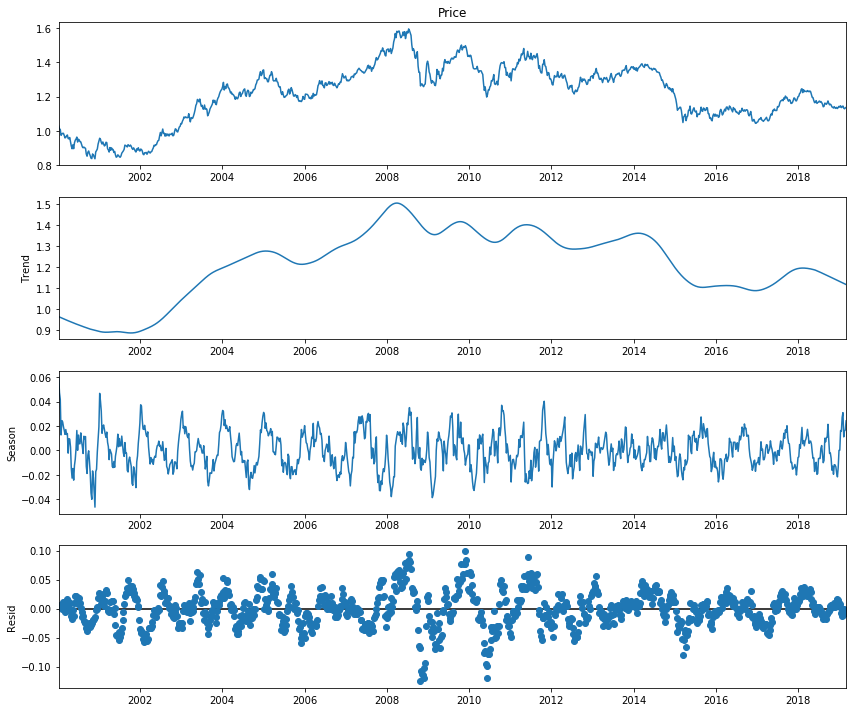

In [36]:
result = STL(series).fit()
result.plot()
plt.tight_layout()
plt.show();

 we have our decomposed series, from top down: Raw Weekly Price, Trend, Season and Residual (a.k.a Remainder). If we want to try to forecast the EURUSD price movements? We could start by applying a simple “persistence model”, this is the simplest kind of model which works by assigning the last observed value as the prediction for the following value, i.e. it just “persists” the last price forward. As you can see its not exactly a very sophisticated model, however its a start and it provides a baseline of performance for the problem that we can use for comparison with an auto regression model. We will score our model performance using the Root Mean Squared Error (RMSE).

The code below begins by creating a series of “1-period forward” predictions, just shifting the last price forward one week and comparing that value with the actual price that was seen at that time. It then uses the scikit-learn “mean_squared_error” function to calculate the MSE, which we then simply take the square root of to produce the RMSE. We receive a value of 0.013.

You will notice that the RMSE is only calculated for the period corresponding to a “testing dataset”, which in this case is the last 30% of the data. This allows us to compare performance with more sophisticated models that require “training” over a “training” dataset, before they can be used for prediction purposes, the performance of which we judge when carried out over a “testing” dataset.

This ensures that we only judge a models performance when it is used to predict parts of a time series that it didn’t have available at the time of optimising its parameters.

The mean squared error, or MSE, is calculated as the average of the squared forecast error values. The error values are in squared units of the predicted values and a mean squared error of zero indicates perfect prediction skills, or “no error” in effect.

Finally, we plot just the last few data points, allowing us to see more clearly how the predicted values relate to the actual values observed.

Test RMSE: 0.01304


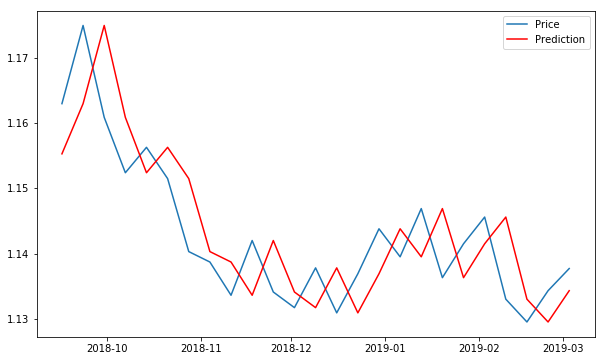

In [37]:
predictions = series.shift(1).dropna()
test_score = np.sqrt(mean_squared_error(series[int(len(series) * 0.7)+1:], predictions.iloc[int(len(series) * 0.7):]))
print('Test RMSE: %.5f' % test_score)
plt.figure(figsize=(10, 6))
plt.plot(series.iloc[-25:], label='Price')
plt.plot(predictions[-25:], color='red', label='Prediction')
plt.legend()
plt.show()

scatter plot of the predicted vs the actual weekly percentage change to see if there is any noticeable relationship. We do this followed by calculating the Mean Absolute Error (MAE) of the predictions (i.e. by how much, on average did our prediction differ from the observed value)

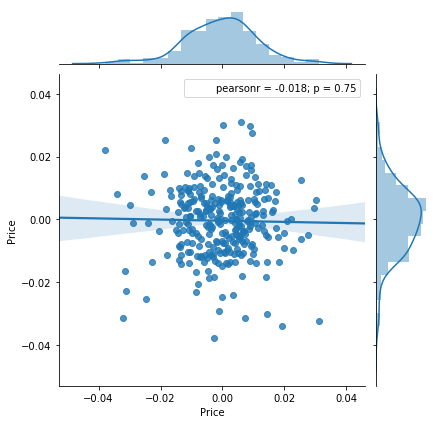

The MAE is 0.0125


In [39]:
ax = sns.jointplot(series.iloc[-int(len(series) * 0.3):].pct_change(),
            predictions.iloc[-int(len(series) * 0.3):].pct_change(), kind='reg')

plt.show()
mae = round(abs(series.iloc[-int(len(series) * 0.3):].pct_change() - predictions.iloc[-int(len(series) * 0.3):].pct_change()).mean(),4)
print(f'The MAE is {mae}')

Looking at the above plot it seems as though there is no discernable relationship between our predictions and our observed values when considering the weekly percentage change in the EURUSD price.

If we calculate the “hit rate” of how often we are able to correctly predict the direction of next week’s move in the EURUSD, we can see that it is almost exactly 50% (in fact its a little worse than that even) – no better than completely randomly guessing!

In [40]:
price_pred = pd.concat([series.iloc[-int(len(series) * 0.3):].pct_change(), predictions.iloc[-int(len(series) * 0.3):].pct_change()], axis=1)
price_pred.dropna(inplace=True)
price_pred.columns = ['Price', 'preds']

price_pred['hit'] = np.where(np.sign(price_pred['Price']) == np.sign(price_pred['preds']), 1, 0)

print(f"Hit rate: {round((price_pred['hit'].sum() / price_pred['hit'].count()) * 100,2)}%")

Hit rate: 48.49%


Now that we have our “baseline” model score, we have something to compare subsequent models to. Let’s try our predictions using an autoregressive model, which is basically a linear regression model that uses lagged values of variables as subsequent input variables.

There is a decision to make as to what lag to use for our input variable – the simplest approach for now is to use the AR class found in statsmodels which automatically selects an appropriate lag using various statistical tests and proceeds to train a linear regression model.

The code below takes our EURUSD time series and splits it into a “training” and “testing” dataset and creates an empty list which we are going to use to store our predictions. This is because this time we are going to make our weekly predictions one by one, in a “walk-forward” manner.

We are going to iterate through a “for-loop” with the number of loops dictated by the length of our test data – each time through the loop we are going to create our AR model and feed it the training data set to train and fit it on. Once fit, we generate a 1 period-forward prediction (which takes the form of a single value), we append that value to our predictions list to store it. Importantly, we also extract the value from the test data whose index corresponds to the current value of our for-loop iterator and append that value to the end of our training data.

The next run through our loops, we train and fit the model again but this time there is a new observation in the training data that we feed it, i.e. the value we just appended on the last for-loop.

This means the training data will grow as each loop sees a new observation added to the training data. This just mimics the real-life passage through time where we have an additional day’s worth of data available to us vs the day before. It just ensures also that we are not exposing our model to “look-forward” bias and training it using data that wouldn’t have been available at that time.

Like before, the MSE is calculated and the last 25 data points are plotted – the observed prices vs the predictions made by the model.

Test MSE: 0.01327


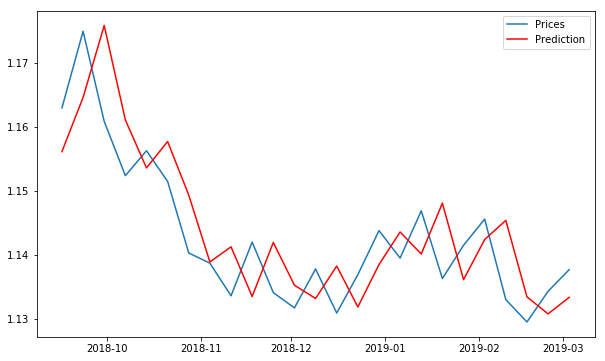

In [41]:
historic = series.iloc[:int(len(series) * 0.7)].tolist()
test = series.iloc[int(len(series) * 0.7):]
predictions = []
for i in range(len(test)):
    model = AR(historic)
    model_fit = model.fit()
    pred = model_fit.predict(start=len(historic), end=len(historic), dynamic=False)
    predictions.append(pred[0])
    historic.append(test[i])
    
predictions = pd.Series(predictions, index=test.index)
    
test_score = np.sqrt(mean_squared_error(test, predictions))
print('Test MSE: %.5f' % test_score)
# plot results
plt.figure(figsize=(10, 6))
plt.plot(test.iloc[-25:], label='Prices')
plt.plot(predictions.iloc[-25:], color='red', label='Prediction')
plt.legend()
plt.show()

Again we get an MSE very close to 0.013, this time its actually ever so slightly higher at 0.1327. The reason that the two models produce such a similar MSE is down to the fact that neither model seems to be any good at making predictions. If we were to look at the average weekly price move in the EURUSD over the period covered by our test data, I have as sneaking suspicion it would turn out to be somewhere in the region of…you guessed it – 0.013.

That’s the same as saying our model predictions are no better, on average than saying the price isn’t going to move at all, which is obviously a useless prediction.

Plotting the same scatter plot as before, but this time for the latest model confirms our suspicions – again there is no discernible relationship between our predictions of the weekly percentage price moves, and those we actually observe, and again our MAE is pretty much the same as the first model.

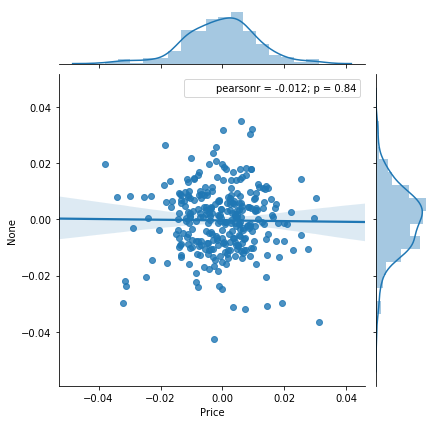

The MAE is 0.0125916852


In [42]:
sns.jointplot(series.iloc[-int(len(series) * 0.3):].pct_change(),
            predictions.iloc[-int(len(series) * 0.3):].pct_change(), kind='reg' )
plt.show()
mae = round(abs(test.pct_change() - predictions.pct_change()).mean(),10)
print(f'The MAE is {mae}')

Looking at the above plot it seems as though again there is no discernible relationship between our predictions and our observed values when considering the weekly percentage change in the EURUSD price.

If we quickly calculate the “hit rate” of how often we are able to correctly predict the direction of next week’s move in the EURUSD, again we see a figure that’s slightly worse than 50%.

In [43]:
price_pred = pd.concat([test.pct_change(), predictions.pct_change()], axis=1)
price_pred.dropna(inplace=True)
price_pred.columns = ['Price', 'preds']
price_pred['hit'] = np.where(np.sign(price_pred['Price']) == np.sign(price_pred['preds']), 1, 0)
print(f"Hit rate: {round((price_pred['hit'].sum() / price_pred['hit'].count()) * 100,2)}%")

Hit rate: 48.16%


How can we use the decomposition methods to help improve our predictive abilities? As mentioned before, each component has varying characteristics that suggest they should be dealt with individually in a more specialised manner. If we can improve our predictions by breaking a time series into its component, use our models to predict the components individually then in theory all we have to do is recombine the predictions back into a full time series (i.e. just add them all back together) and we should end up with a more accurate overall prediction.

So lets first decompose the EURUSD series using the Hodrick-Prescott Filter and store each component.
We do this below and then plot the components as a quick reminder so as to what they look like.

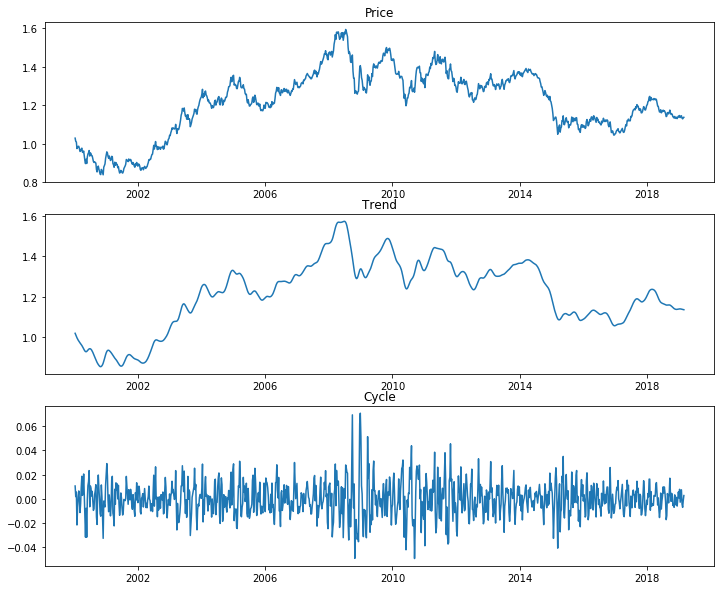

In [44]:
cycle, trend = sm.tsa.filters.hpfilter(series, 50)
fig, ax = plt.subplots(3,1)
ax[0].plot(series)
ax[0].set_title('Price')
ax[1].plot(trend)
ax[1].set_title('Trend')
ax[2].plot(cycle)
ax[2].set_title('Cycle')
plt.show()

Now we have to write the code to run our AR model in the same fashion as before, but this time with the decomposed series as inputs.

Test for trend MSE: 0.00015550048837704788


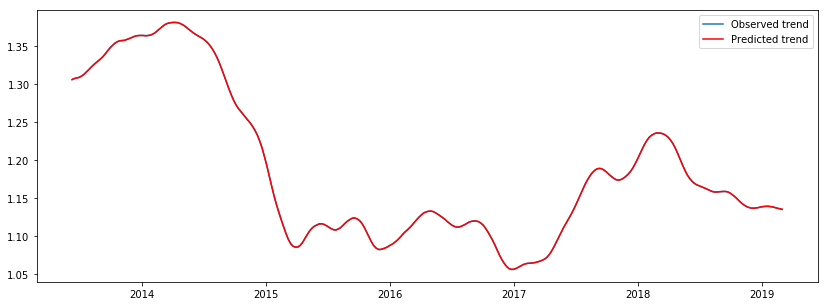

Test for cycle MSE: 0.008775137501317004


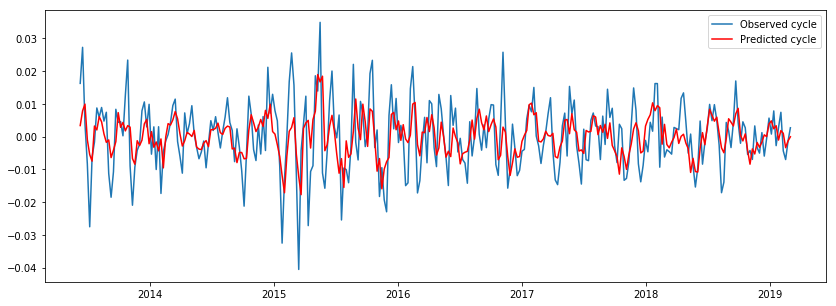

In [45]:
component_dict = {'cycle': cycle, 'trend': trend}
prediction_results = []
for component in ['trend', 'cycle']:
    historic = component_dict[component].iloc[:int(len(series) * 0.7)].tolist()
    test = component_dict[component].iloc[int(len(series) * 0.7):]
    predictions = []
    for i in range(len(test)):
        model = AR(historic)
        model_fit = model.fit()
        pred = model_fit.predict(start=len(historic), end=len(historic), dynamic=False)
        predictions.append(pred[0])
        historic.append(test[i])
    predictions = pd.Series(predictions, index=test.index, name=component)
    prediction_results.append(predictions)
    test_score = np.sqrt(mean_squared_error(test, predictions))
    plt.figure(figsize=(14, 5))
    print(f'Test for {component} MSE: {test_score}')
    # plot results
    plt.plot(test.iloc[:], label='Observed '+component)
    plt.plot(predictions.iloc[:], color='red', label='Predicted '+component)
    plt.legend()
    plt.show();

It looks like only one line has been plotted for the trend series, but it only just looks that way as the predicted values are so close to the actual decomposed values that one line is hidden by the other.

Next we “recompose” our data in an additive manner and calculate the RMSE when comparing the resulting combined prediction performance against the observed values.

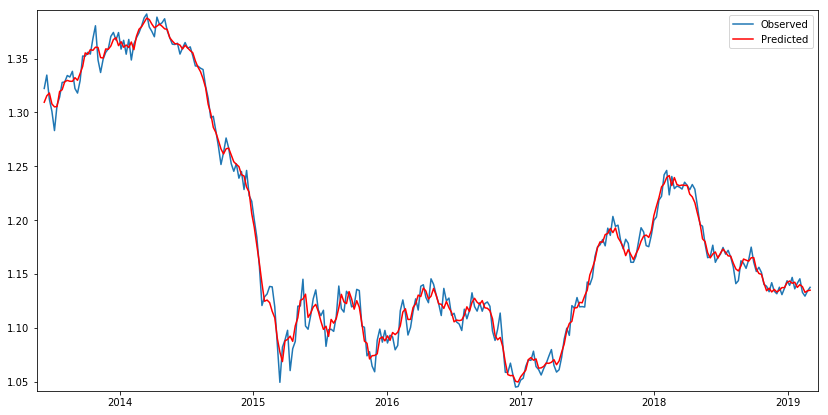

RMSE: 0.008746050423719945


In [46]:
recomposed_preds = pd.concat(prediction_results,axis=1).sum(axis=1)
recomposed_preds.name = 'recomposed_preds'
plt.figure(figsize=(14, 7))
plt.margins(0.01)
plt.plot(series.iloc[int(len(series) * 0.7):], label='Observed')
plt.plot(recomposed_preds, color='red', label='Predicted')
plt.legend()
plt.show()
test_score = np.sqrt(mean_squared_error(series.iloc[int(len(series) * 0.7):], recomposed_preds))
print(f'RMSE: {test_score}')

Ok so it looks like our RMSE has fallen, now sitting around 0.0087 as opposed to the two previous attempts which were producing values closer to 0.013. That’s a fall of about 33%. Does that mean there is something to be said for this decompose/recompose approach?

Let’s plot our scatter chart and calculate the new MAE for this model.

The MAE is 0.0085455491


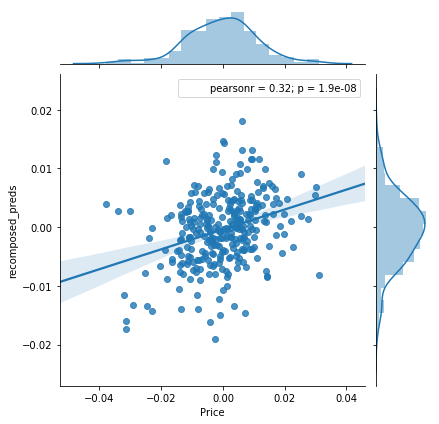

In [47]:
sns.jointplot(series.iloc[-int(len(series) * 0.3):].pct_change(),
            recomposed_preds.iloc[-int(len(series) * 0.3):].pct_change(), kind='reg');

mae = round(abs(series.iloc[-int(len(series) * 0.3):].pct_change() - 
                recomposed_preds.iloc[-int(len(series) * 0.3):].pct_change()).mean(),10)
print(f'The MAE is {mae}')

The MAE has fallen also, from a previous figure of around 0.013 to 0.0085 – again a difference of around 33%. Not only that but the distribution of data points on the scatter plot has taken in a slightly different shape – the regression line shows more of a positive relationship between the observations and our predictions.

As shown below, we are now able to predict the direction of the next week’s price move 60% of the time, rather than a random 50% as we saw with the last two attempts.

In [48]:
price_pred = pd.concat([series.iloc[-int(len(series) * 0.3):].pct_change(),recomposed_preds.iloc[-int(len(series) * 0.3):].pct_change()], axis=1)
price_pred.dropna(inplace=True)

price_pred['hit'] = np.where(np.sign(price_pred['Price']) == np.sign(price_pred['recomposed_preds']), 1, 0)

print(f"Hit rate: {round((price_pred['hit'].sum() / price_pred['hit'].count()) * 100,2)}%")

Hit rate: 60.2%


Although the RMSE, MAE and Hit Rate have all significantly improved when we use the decompose/recompose approach, even with not a single attempt to optimise our model parameters, we would do well not to get too excited too quickly.

I chose to demonstrate the use of the HP Filter decomposition method first on purpose. One needs to be careful when applying new methods – if we don’t understand fully the way things work “behind the scenes” we can end up getting caught out quite badly.

There is a slight issue with the HP filter method. The decomposition algorithm makes use of observations that come both before and after the current estimate. This injects an element of “look-forward” bias into our analysis which is one of the most common biases that infect peoples analysis and trading/predictive models. In this case, once you know exactly how the HP Filter is calculated it seems quite obvious, but if you never took the time to familiarise yourself with the calculation method that could easily fly under the radar.

As a side note, algorithmic/systematic trading model backtesting is an area that is ABSOLUTELY ripe for and rife with various biases, with look-forward bias being near, if not top of the list.

So basically the above means that the HP Filter produces decomposed series that contain information from the “future”, making our predictions more accurate in general and causing our recomposed predictions to be misleadingly accurate also.

So what happens when we revert back to using a decomposition method that doesn’t “cheat” and avail itself of “future information” when decomposing a time series.

Well let’s return now to the STL Decomposition method. Below is a decomposition and visual of the results.

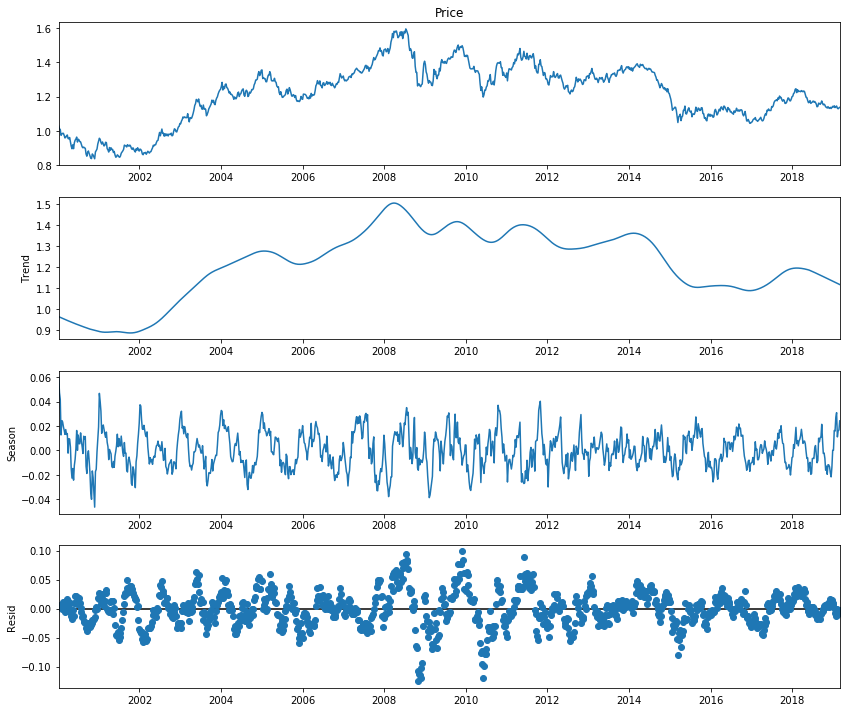

In [49]:
result = STL(series).fit()
result.plot()
plt.show()

The individual decomposed series can be accessed from the result object as follows, by using either “trend”, “seasonal” or “resid”. As an example we print out the first 5 rows of the seasonal series below.

In [50]:
result.seasonal.head()

Date
2000-01-09    0.060011
2000-01-16    0.047314
2000-01-23    0.041816
2000-01-30    0.012704
2000-02-06    0.024431
Freq: W-SUN, Name: season, dtype: float64

Now we have to write the code to run our AR model in the same fashion as before.

Test for seasonal MSE: 0.006831502745315085


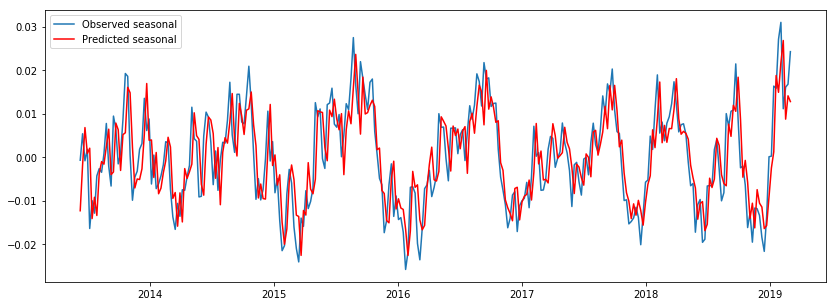

Test for trend MSE: 2.953681686572797e-05


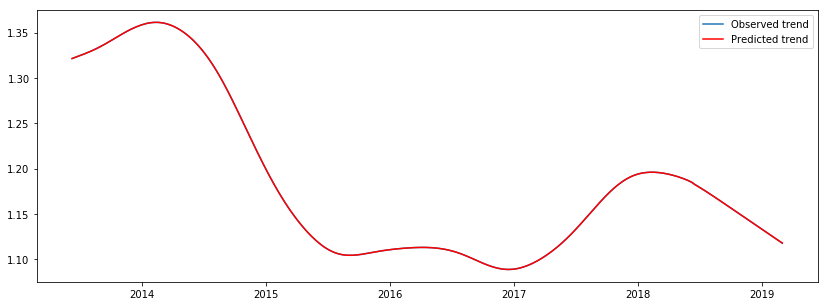

Test for residual MSE: 0.009794499939748081


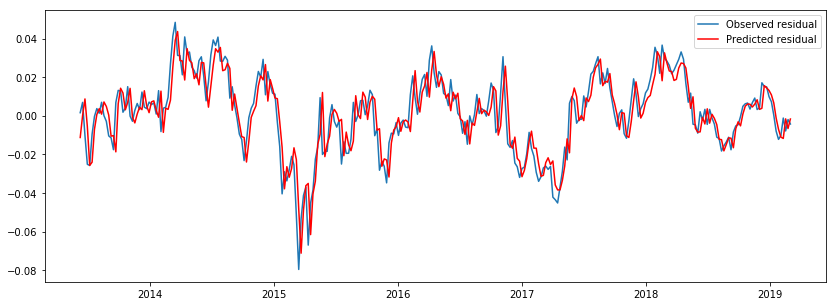

In [51]:
component_dict = {'seasonal': result.seasonal, 'trend': result.trend, 'residual': result.resid}
prediction_results = []
for component in ['seasonal', 'trend', 'residual']:
    historic = component_dict[component].iloc[:int(len(series) * 0.7)].tolist()
    test = component_dict[component].iloc[int(len(series) * 0.7):]
    predictions = []
    for i in range(len(test)):
        model = AR(historic)
        model_fit = model.fit()
        pred = model_fit.predict(start=len(historic), end=len(historic), dynamic=False)
        predictions.append(pred[0])
        historic.append(test[i])
    predictions = pd.Series(predictions, index=test.index, name=component)
    prediction_results.append(predictions)
    test_score = np.sqrt(mean_squared_error(test, predictions))
    plt.figure(figsize=(14, 5))
    print(f'Test for {component} MSE: {test_score}')
    # plot results
    plt.plot(test.iloc[:], label='Observed '+component)
    plt.plot(predictions.iloc[:], color='red', label='Predicted '+component)
    plt.legend()
    plt.show()

Next we “recompose” our data in an additive manner and calculate the RMSE when comparing the resulting combined prediction performance against the observed values as we did for the HP Filter model.

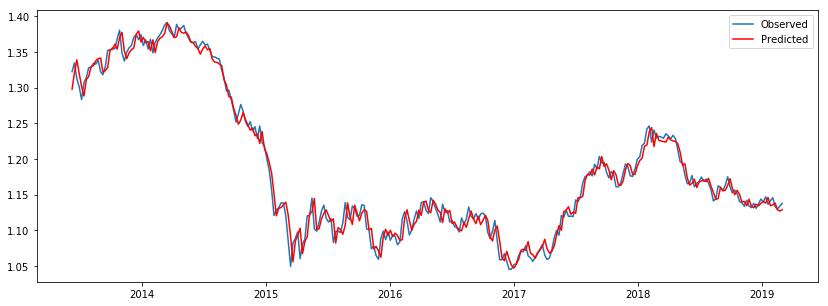

RMSE: 0.012574927660308545


In [52]:
recomposed_preds = pd.concat(prediction_results,axis=1).sum(axis=1)
plt.figure(figsize=(14, 5))
plt.plot(series.iloc[int(len(series) * 0.7):], label='Observed')
plt.plot(recomposed_preds, color='red', label='Predicted')
plt.legend()
plt.show()
test_score = np.sqrt(mean_squared_error(series.iloc[int(len(series) * 0.7):], recomposed_preds))
print(f'RMSE: {test_score}')

That RMSE score looks like its moved in the wrong direction ( 0.0126)…its jumped right back to the kind of values we were seeing for our first two models, the “Persistence” model and the AR model that we were using with undecomposed data – i.e. using the raw price series.

That doesn’t bode well for us. How does the MAE and scatter plot of weekly percentage price changes look (observed vs predicted values).

The MAE is 0.0120168244


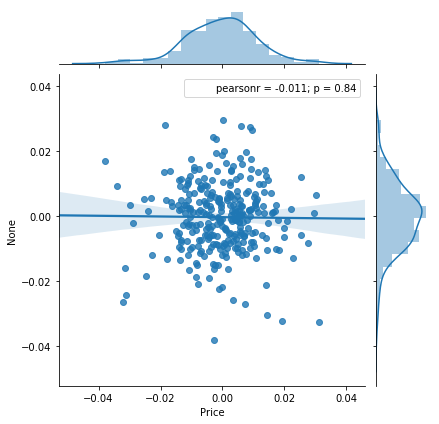

In [53]:
sns.jointplot(series.iloc[-int(len(series) * 0.3):].pct_change(),
            recomposed_preds.iloc[-int(len(series) * 0.3):].pct_change(), kind='reg');

mae = round(abs(series.iloc[-int(len(series) * 0.3):].pct_change() - 
                recomposed_preds.iloc[-int(len(series) * 0.3):].pct_change()).mean(),10)
print(f'The MAE is {mae}')

Our MAE is also back around the previously seen values, and just to confirm what should now be clear to us, the Hit Ratio is back at the 50% level. That translates as “your model is no better at predicting the forthcoming weeks price change direction than is the toss of a fair coin”.

In [54]:
price_pred = pd.concat([series.iloc[-int(len(series) * 0.3):].pct_change(), 
                recomposed_preds.iloc[-int(len(series) * 0.3):].pct_change()], axis=1)
price_pred.dropna(inplace=True)
price_pred.columns = ['Price', 'preds']
price_pred['hit'] = np.where(np.sign(price_pred['Price']) == np.sign(price_pred['preds']), 1, 0)
print(f"Hit rate: {round((price_pred['hit'].sum() / price_pred['hit'].count()) * 100,2)}%")

Hit rate: 51.17%


We have seen that the outcome of the decomposition method used hugely affects the final predictions. The AR model parameters were not estimated using future observations, nor was the STL Decomposition so its not a huge shock that in this instance it didn’t provide a magic bullet to solve our prediction problem.

What’s worth noting, as mentioned before, is that one need to take great care when using certain methods and and tools such as decomposition. Even though the AR model that was used to predict the values of the decomposed series output by the HP Filter doesn’t suffer from look-forward bias itself, the way the series are separated during the decomposition itself uses future movements unknown at the time of estimation and therefore taints the model’s predictive output.